In [1]:
!pip install brainiak

     |████████████████████████████████| 6.8 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 27.4 MB/s 
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
     |████████████████████████████████| 2.4 MB 35.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 59 kB 5.8 MB/s 
     |████████████████████████████████| 6.2 MB 23.5 MB/s 
     |████████████████████████████████| 2.8 MB 13.9 MB/s 
  Created wheel for brainiak: filename=brainiak-0.11-cp37-cp37m-linux_x86_64.whl size=1104117 sha256=6ea8d95922fb6119642ed6ff9a9b7e00f61bc4062a61a1afa61d350148134fa9
  Stored in directory: /root/.cache/pip/wheels/9b/a1/5f/b7ac0f991e9f859ccf0f58e531343f763da84c218016adee79
  Created wheel for mpi4py:

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from brainiak.funcalign.srm import SRM
from brainiak.isc import isc

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
roi = 'A1'
filepath = 'drive/MyDrive/fMRI_music_data/%s_by_subject_sorted_conds/'%roi
subjects = ['03','15','20','23']
n_sub = len(subjects)

In [4]:
# load data from one subject for a quick sanity check
this_subj = subjects[0]
test = np.load(filepath+'%s_sub-1%s.npy'%(roi,this_subj))
print(test.shape)

(516, 1776)


There are 516 voxels in A1. There are 1776 total time points: 148 TRs per run * 12 runs.

In [5]:
# load in the data from all subjects
data = []
for subj in subjects: 
  data.append(np.load(filepath+'%s_sub-1%s.npy'%(roi,subj)))

# recast the list into an array and check the shape
data = np.asarray(data)
print(data.shape)

(4, 516, 1776)


Reshape the data so that it's subjects x voxels x TRs x conds x runs. This gives flexibility to select training and testing data for SRM later.

In [6]:
n_voxels = data.shape[1]
n_TRs = 148
n_conds = 4
n_runs = 3

orig_data = np.copy(data)
orig_data = np.reshape(orig_data,(n_sub,n_voxels,n_TRs,n_conds,n_runs),order='F')
print(orig_data.shape)

(4, 516, 148, 4, 3)


As long as this array acts like the toy example (see earlier version and `ryc_toy_reshaping.ipynb`), then `order = 'F'` should keep the individual runs intact during the reshaping.

Before looking at any runs or conditions in particular, first we'll split the data into two folds and perform a k sweep. The following code is adapted in part from `ryc_TRxTR-SRM_090721.ipynb` which was adapted from the BrainIAK tutorial on SRM (number 11). The outcome measure will be feature-wise ISC, averaged over features and subjects.

In [7]:
# split the data into two halves
data_firsthalf = data[:,:,:data.shape[2]//2]
data_secondhalf = data[:,:,data.shape[2]//2:]
print(data_firsthalf.shape)
print(data_secondhalf.shape)

(4, 516, 888)
(4, 516, 888)


(The training and testing data for SRM don't necessarily have to be the same size, but they are in this case.)

In [11]:
# set which k-values to use
k_low = np.arange(1,10).tolist()
k_mid = np.arange(10,100,10).tolist()
k_high = np.arange(100,400,50).tolist()
k = k_low + k_mid + k_high
print(k)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350]


In [45]:
# first fold
train_data = data_firsthalf
test_data = data_secondhalf

# normalize data in time for each subject
for s in range(len(subjects)):
  train_data[s] = stats.zscore(train_data[s],axis=1)
  test_data[s] = stats.zscore(test_data[s],axis=1)

print(train_data.shape)

(4, 516, 888)


In [46]:
n_iter = 20

isc_means = []

for features in k:

  # create the SRM object
  srm = SRM(n_iter=n_iter, features=features)

  # fit the SRM data
  srm.fit(train_data)
  print('SRM with %d features has been fit'%features)

  # transform the test data
  shared_test = srm.transform(test_data)

  # reshape data for ISC
  # data has to be TRs x voxels/features x subjects
  shared_test = np.asarray(shared_test)
  shared_test = np.transpose(shared_test,axes=[2,1,0])

  # compute ISC
  shared_test_isc = isc(shared_test)

  # average over subjects
  isc_by_feat = np.average(shared_test_isc,axis=0)

  # compute the mean ISC value
  isc_means.append(np.average(isc_by_feat))

SRM with 1 features has been fit
SRM with 2 features has been fit
SRM with 3 features has been fit
SRM with 4 features has been fit
SRM with 5 features has been fit
SRM with 6 features has been fit
SRM with 7 features has been fit
SRM with 8 features has been fit
SRM with 9 features has been fit
SRM with 10 features has been fit
SRM with 20 features has been fit
SRM with 30 features has been fit
SRM with 40 features has been fit
SRM with 50 features has been fit
SRM with 60 features has been fit
SRM with 70 features has been fit
SRM with 80 features has been fit
SRM with 90 features has been fit
SRM with 100 features has been fit
SRM with 150 features has been fit
SRM with 200 features has been fit
SRM with 250 features has been fit
SRM with 300 features has been fit
SRM with 350 features has been fit


In [30]:
# compute voxelwise ISC
# data has to be TRs x voxels/features x subjects
test_isc = isc(np.transpose(test_data,axes=[2,1,0]))
print(test_isc.shape)

# average ISC values across subjects
isc_by_voxel = np.average(test_isc,axis=0)
print(isc_by_voxel.shape)

# average ISC values across voxels
isc_voxel_avg = np.average(isc_by_voxel)

(4, 516)
(516,)


Run the same analysis with the other fold.

In [47]:
# second fold
train_data = data_secondhalf
test_data = data_firsthalf

# normalize data in time for each subject
for s in range(len(subjects)):
  train_data[s] = stats.zscore(train_data[s],axis=1)
  test_data[s] = stats.zscore(test_data[s],axis=1)
# this is a redundant step when there are two folds

In [48]:
n_iter = 20

for features in k:

  # create the SRM object
  srm = SRM(n_iter=n_iter, features=features)

  # fit the SRM data
  srm.fit(train_data)
  print('SRM with %d features has been fit'%features)

  # transform the test data
  shared_test = srm.transform(test_data)

  # reshape data for ISC
  # data has to be TRs x voxels/features x subjects
  shared_test = np.asarray(shared_test)
  shared_test = np.transpose(shared_test,axes=[2,1,0])

  # compute ISC
  shared_test_isc = isc(shared_test)

  # average over subjects
  isc_by_feat = np.average(shared_test_isc,axis=0)

  # compute the mean ISC value
  isc_means.append(np.average(isc_by_feat))

SRM with 1 features has been fit
SRM with 2 features has been fit
SRM with 3 features has been fit
SRM with 4 features has been fit
SRM with 5 features has been fit
SRM with 6 features has been fit
SRM with 7 features has been fit
SRM with 8 features has been fit
SRM with 9 features has been fit
SRM with 10 features has been fit
SRM with 20 features has been fit
SRM with 30 features has been fit
SRM with 40 features has been fit
SRM with 50 features has been fit
SRM with 60 features has been fit
SRM with 70 features has been fit
SRM with 80 features has been fit
SRM with 90 features has been fit
SRM with 100 features has been fit
SRM with 150 features has been fit
SRM with 200 features has been fit
SRM with 250 features has been fit
SRM with 300 features has been fit
SRM with 350 features has been fit


In [49]:
isc_means_all = np.asarray(isc_means)
isc_means_all = np.reshape(isc_means_all, (len(k),-1), order='F')
print(isc_means_all)

[[0.17040531 0.2688149 ]
 [0.09223669 0.19570192]
 [0.11961308 0.13969202]
 [0.10723941 0.11513644]
 [0.10747976 0.09897889]
 [0.09832691 0.08468464]
 [0.0744407  0.09110054]
 [0.09314726 0.07263504]
 [0.07186306 0.06454451]
 [0.08014554 0.07807812]
 [0.06768626 0.05684233]
 [0.05597859 0.05190264]
 [0.05324022 0.04584541]
 [0.05353758 0.04632108]
 [0.05371674 0.04177021]
 [0.05037357 0.04107297]
 [0.0485031  0.04030638]
 [0.04910552 0.04083064]
 [0.04635918 0.042661  ]
 [0.04358979 0.03582071]
 [0.04105164 0.03588303]
 [0.0397938  0.03468439]
 [0.03881202 0.03379392]
 [0.03797471 0.03180785]]


In [52]:
avg_isc_means_all = np.average(isc_means_all,axis=1)

In [34]:
# compute voxelwise ISC
# data has to be TRs x voxels/features x subjects
test_isc = isc(np.transpose(test_data,axes=[2,1,0]))

# average ISC values across subjects
isc_by_voxel = np.average(test_isc,axis=0)

# average ISC values across voxels
isc_voxel_avg_2 = np.average(isc_by_voxel)
# combine results from first fold and second fold
overall_isc_voxel_avg = np.average([isc_voxel_avg,isc_voxel_avg_2])

In [35]:
print(overall_isc_voxel_avg)

0.029575467341920673


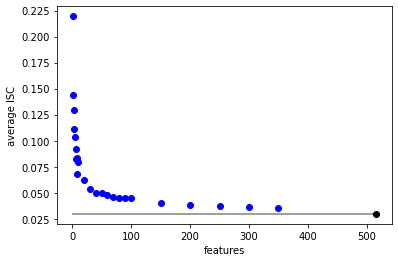

In [53]:
fig,ax = plt.subplots()
ax.scatter(k,avg_isc_means_all,color='blue');
ax.scatter(n_voxels,overall_isc_voxel_avg,color='black')
ax.hlines(overall_isc_voxel_avg,0,n_voxels,alpha=0.5)
ax.set_xlabel('features')
ax.set_ylabel('average ISC');

Fitting an SRM with one features seems to do the best. What does the TRxTR matrix look like if we fit two features?

In [54]:
print(data.shape)

(4, 516, 1776)


In [84]:
n_iter = 20
features = 2

# create the SRM object
srm = SRM(n_iter=n_iter, features=features)

# fit the SRM data
srm.fit(data)

# transform the data
shared_data = srm.transform(data)

In [87]:
shared_data_avg = np.average(np.asarray(shared_data),axis=0)
print(shared_data_avg.shape)

(2, 1776)


In [88]:
shared_corr = np.corrcoef(shared_data_avg,rowvar=False)
print(shared_corr.shape)

(1776, 1776)


''

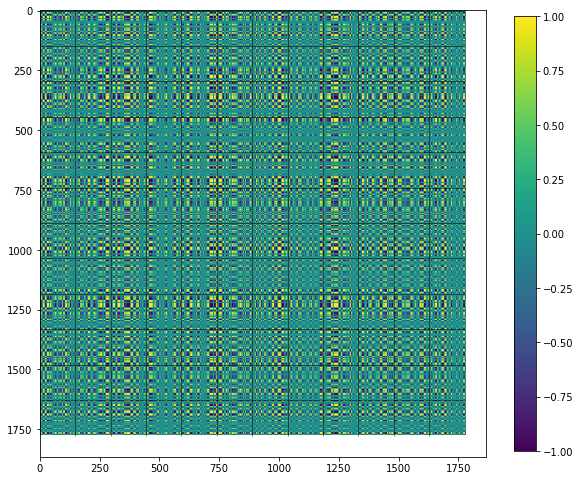

In [102]:
fig,ax = plt.subplots(figsize=(10,10))
im = ax.imshow(shared_corr)
fig.colorbar(im,shrink=0.8)
for i in range(n_conds*n_runs):
  ax.hlines(n_TRs*i, 0, total_TRs, linewidth=0.5)
  ax.vlines(n_TRs*i, 0, total_TRs, linewidth=0.5)
;

In [70]:
data_avg = np.average(data,axis=0)
print(data_avg.shape)

(516, 1776)


In [82]:
corr = np.corrcoef(data_avg,rowvar=False)

In [92]:
total_TRs = data_avg.shape[1]
print(total_TRs)

1776


''

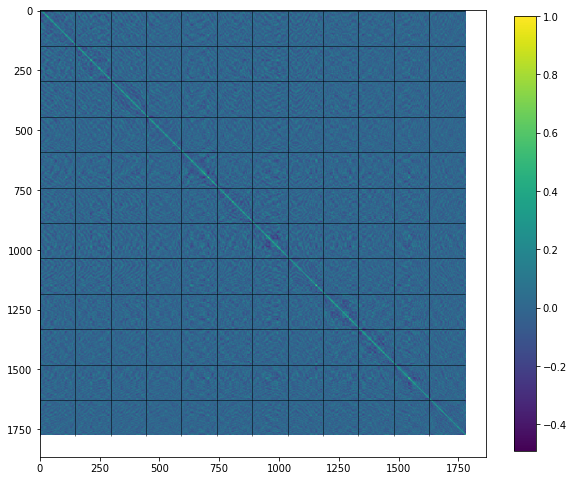

In [101]:
fig,ax = plt.subplots(figsize=(10,10))
im = ax.imshow(corr)
fig.colorbar(im,shrink=0.8)
for i in range(n_conds*n_runs):
  ax.hlines(n_TRs*i, 0, total_TRs, linewidth=0.5)
  ax.vlines(n_TRs*i, 0, total_TRs, linewidth=0.5)
;

Still trying to figure out what this one feature is in SRM with k=1.

In [103]:
n_iter = 20
features = 1

# create the SRM object
srm = SRM(n_iter=n_iter, features=features)

# fit the SRM data
srm.fit(data)

# transform the data
shared_data1 = srm.transform(data)

In [105]:
shared1 = np.asarray(shared_data1)
print(shared1.shape)

(4, 1, 1776)


In [106]:
sh1_reshape = np.reshape(shared1, (shared1.shape[0],-1))
print(sh1_reshape.shape)

(4, 1776)


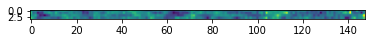

In [113]:
plt.imshow(sh1_reshape[:,:n_TRs]);

It's puzzling that feature-wise ISC is best when k=1. Splitting the data right down the middle for two folds is probably not the best approach with this data. I don't know how to visualize the feature to see if it's related to the fact that there are twelve distinct runs.